#Install


In [1]:
!pip install opencv-python
!pip install keras
!pip install tensorflow

# Imports


In [2]:
import os
import shutil
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
import keras
from collections import deque
import matplotlib.pyplot as plt
plt.style.use("seaborn")

%matplotlib inline

from sklearn.model_selection import train_test_split

from keras.layers import *
from keras.models import Model, Sequential, load_model
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from keras import backend as K

<ipython-input-2-e32204545b3a>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Extract Frames

In [4]:
# ขนาดของวิดีโอที่ต้องการ Resize
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64
# Predict ทีละ 16 เฟรม
SEQUENCE_LENGTH = 16

# Direct ไปยังไฟล์ที่มีวิดีโอ Dataset อยู่
DATASET_DIR = "/content/drive/MyDrive/ML/dataset/night-time/"

# ชื่อไฟล์แยกระหว่าง Violence และ NonViolence
CLASSES_LIST = ["violence_n","nonviolence_n"]

In [5]:
def frames_extraction(video_path):

    frames_list = []

    # Read the Video File
    video_reader = cv2.VideoCapture(video_path)
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    for frame_counter in range(SEQUENCE_LENGTH):

        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)
        # Reading
        success, frame = video_reader.read()

        if not success:
            break

        # Resize ให้เป็น 64, 64
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize
        normalized_frame = resized_frame / 255

        # Append frame ที่ normalized ไว้แล้วเข้า frame list
        frames_list.append(normalized_frame)


    video_reader.release()

    return frames_list

#Create Dataset

In [6]:
def create_dataset():

    features = []
    labels = []
    video_files_paths = []
    counter = 0

    for class_index, class_name in enumerate(CLASSES_LIST):

        print(f'\r Extracting Data of Class: {class_name}')


        files_list = os.listdir(os.path.join(DATASET_DIR, class_name))
        for file_name in files_list:

            # Get the complete video path.
            video_file_path = os.path.join(DATASET_DIR, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)
            if len(frames) == SEQUENCE_LENGTH:

                # Append เข้า list ที่สร้างเอาไว้
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

                # แสดงความคืบหน้าของการสร้าง Data
                print_progress(counter, 3200)
                counter += 1

    features = np.asarray(features)
    labels = np.array(labels)

    return features, labels, video_files_paths

In [7]:
# แสดงความคืบหน้า
import sys

def print_progress(count, max_count):
    pct_complete = count / max_count
    msg = "\r- Progress: {0:.1%}".format(pct_complete)
    sys.stdout.write(msg)
    sys.stdout.flush()

Uncomment 2 บรรทัดนี้ ถ้ายังไม่มีไฟล์ Data ที่แยก Feature และ Label ไว้แล้ว เพื่อสร้างไฟล์ data

In [8]:
# features, labels, video_files_paths = create_dataset()

In [9]:
# np.save("/content/drive/MyDrive/ML/dataset/features.npy",features)
# np.save("/content/drive/MyDrive/ML/dataset/labels.npy",labels)
# np.save("/content/drive/MyDrive/ML/dataset/video_files_paths.npy",video_files_paths)

#Load Data


โหลด data ที่ได้แยก Features และ Label ไว้แล้ว

In [10]:
features, labels, video_files_paths = np.load("/content/drive/MyDrive/ML/dataset/features.npy") , np.load("/content/drive/MyDrive/ML/dataset/labels.npy",) ,  np.load("/content/drive/MyDrive/ML/dataset/video_files_paths.npy")

#Split Data

แยก Train และ Test

In [11]:
one_hot_encoded_labels = to_categorical(labels)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(features, one_hot_encoded_labels, test_size = 0.1,
                                                                             shuffle = True)

In [13]:
print(X_train.shape,y_train.shape )
print(X_test.shape, y_test.shape)

(2825, 16, 64, 64, 3) (2825, 2)
(314, 16, 64, 64, 3) (314, 2)


#Mobile NET

import MobileNetV2

In [14]:
from keras.applications.mobilenet_v2 import MobileNetV2

mobilenet = MobileNetV2( include_top=False , weights="imagenet")

#Fine-Tuning
mobilenet.trainable=True

for layer in mobilenet.layers[:-40]:
  layer.trainable=False

mobilenet.summary()

9406464/9406464 [==============================] - 2s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, None, None, 32)       864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, None, None, 32)       128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReL

In [15]:
def create_model():

    model = Sequential()

    #Input
    model.add(Input(shape = (SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    #TimeDistributed ประยุกต์ใช้โมเดลกับแต่ละเฟรมใน sequence
    model.add(TimeDistributed(mobilenet))

    #Dropout เพื่อป้องกันการ overfitting
    model.add(Dropout(0.25))

    #แปลงข้อมูลในแต่ละเฟรมใน sequence จาก 3 มิติให้เป็น 1 มิติ
    model.add(TimeDistributed(Flatten()))

    #BiLSTM สร้าง lstm แบบเดินหน้าและถอยหลัง และนำทั้งสองชั้นมาเข้าด้วยกัน
    lstm_fw = LSTM(units=32)
    lstm_bw = LSTM(units=32, go_backwards = True)
    model.add(Bidirectional(lstm_fw, backward_layer = lstm_bw))

    #ป้องกันการ overfitting อีกครั้ง
    model.add(Dropout(0.25))

    #สร้างชั้น Dense ซึ่งเป็นชั้น Fully-connected
    model.add(Dense(256,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(64,activation='relu'))
    model.add(Dropout(0.25))

    model.add(Dense(32,activation='relu'))
    model.add(Dropout(0.25))

    #Dense ที่มีจำนวนยูนิตเท่ากับจำนวนคลาส และใช้ softmax ในการจัดกลุ่ม
    model.add(Dense(len(CLASSES_LIST), activation = 'softmax'))

    model.summary()
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDist  (None, 16, 2, 2, 1280)    2257984   
 ributed)                                                        
                                                                 
 dropout (Dropout)           (None, 16, 2, 2, 1280)    0         
                                                                 
 time_distributed_1 (TimeDi  (None, 16, 5120)          0         
 stributed)                                                      
                                                                 
 bidirectional (Bidirection  (None, 64)                1319168   
 al)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                        

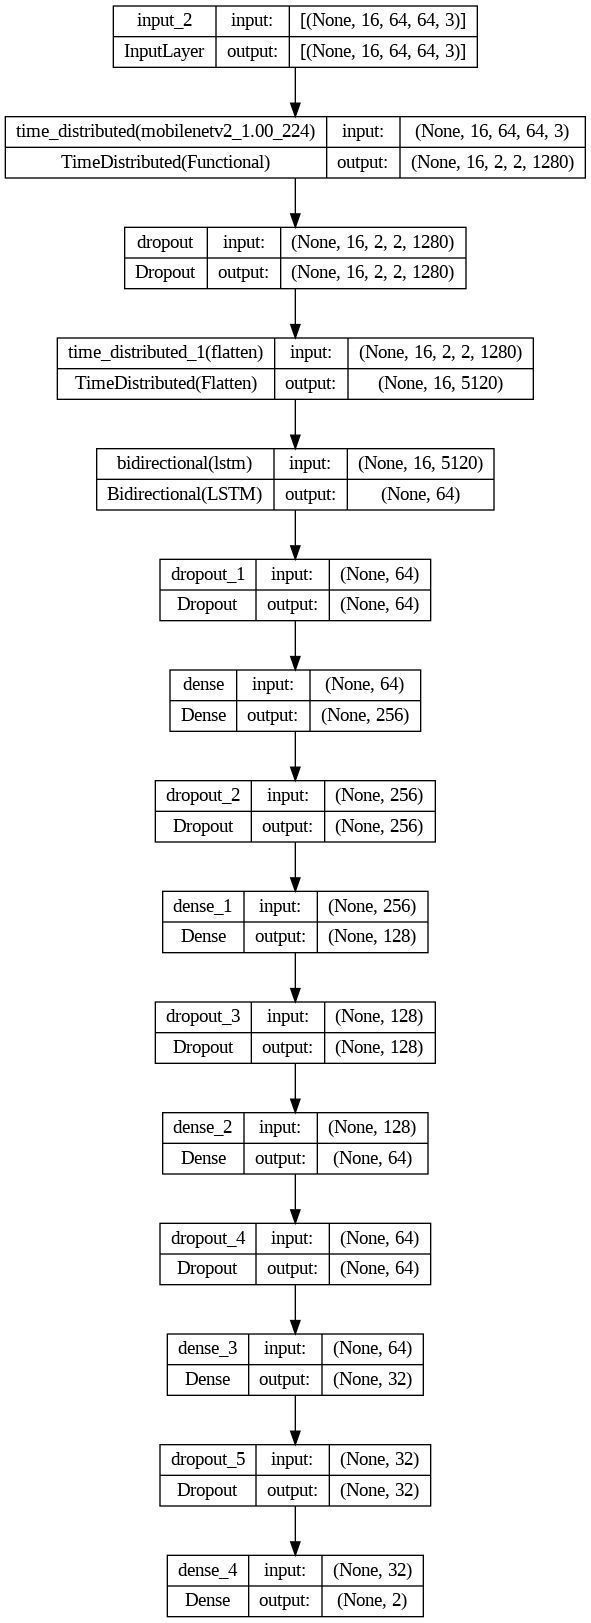

In [16]:
MoBiLSTM_model = create_model()

# Plot
plot_model(MoBiLSTM_model, to_file = 'MobBiLSTM_model_structure_plot.png', show_shapes = True, show_layer_names = True)

#Train


เริ่มทำการเทรนโมเดล

In [17]:
# Create Early Stopping Callback to monitor the accuracy
early_stopping_callback = EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)

# ReduceLROnPlateau ป้องกันการเกิด Overfitting
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                  factor=0.6,
                                                  patience=5,
                                                  min_lr=0.00005,
                                                  verbose=1)

# Compiling
MoBiLSTM_model.compile(loss = 'categorical_crossentropy', optimizer = 'sgd', metrics = ["accuracy"])

# Fitting
MobBiLSTM_model_history = MoBiLSTM_model.fit(x = X_train, y = y_train, epochs = 50, batch_size = 8 ,
                                             shuffle = True, validation_split = 0.2, callbacks = [early_stopping_callback,reduce_lr])

Epoch 1/50
283/283 [==============================] - 34s 74ms/step - loss: 0.6883 - accuracy: 0.5407 - val_loss: 0.6866 - val_accuracy: 0.5292 - lr: 0.0100
Epoch 2/50
283/283 [==============================] - 16s 57ms/step - loss: 0.6554 - accuracy: 0.6075 - val_loss: 0.5879 - val_accuracy: 0.7080 - lr: 0.0100
Epoch 3/50
283/283 [==============================] - 16s 57ms/step - loss: 0.5535 - accuracy: 0.7407 - val_loss: 0.5056 - val_accuracy: 0.7876 - lr: 0.0100
Epoch 4/50
283/283 [==============================] - 16s 57ms/step - loss: 0.4722 - accuracy: 0.7938 - val_loss: 0.4085 - val_accuracy: 0.8283 - lr: 0.0100
Epoch 5/50
283/283 [==============================] - 16s 58ms/step - loss: 0.4285 - accuracy: 0.8204 - val_loss: 0.3899 - val_accuracy: 0.8301 - lr: 0.0100
Epoch 6/50
283/283 [==============================] - 16s 58ms/step - loss: 0.3755 - accuracy: 0.8496 - val_loss: 0.3493 - val_accuracy: 0.8637 - lr: 0.0100
Epoch 7/50
283/283 [==============================] - 16s 

In [18]:
# Plot Train Graph
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):

    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Get the Epochs Count
    epochs = range(len(metric_value_1))

    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'orange', label = metric_name_2)

    plt.title(str(plot_name))

    plt.legend()

แสดงกราฟการเทรน

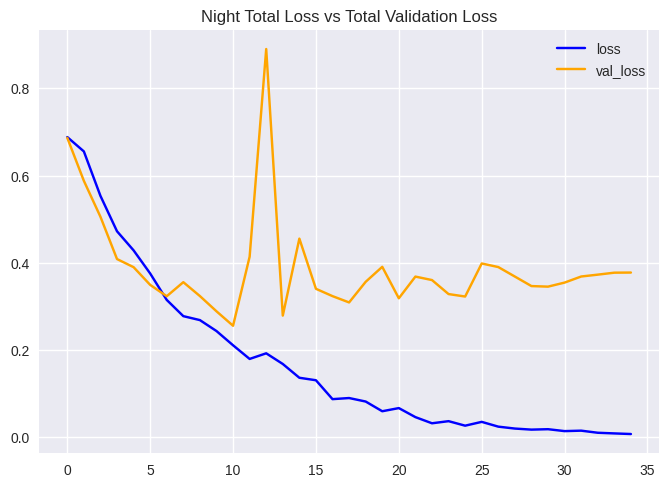

In [19]:
plot_metric(MobBiLSTM_model_history, 'loss', 'val_loss', 'Night Total Loss vs Total Validation Loss')

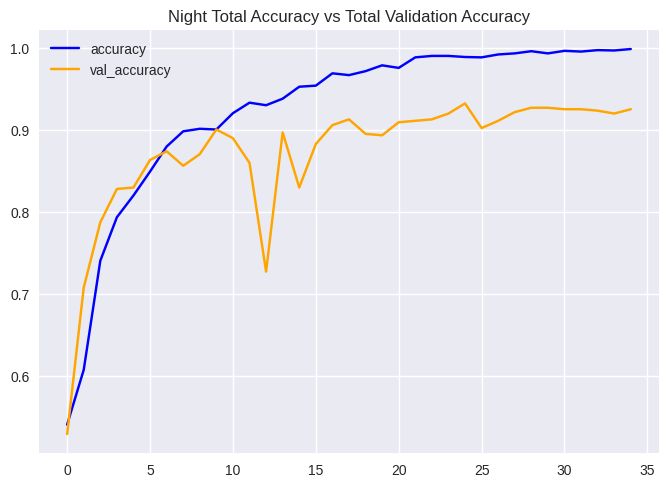

In [20]:
plot_metric(MobBiLSTM_model_history, 'accuracy', 'val_accuracy', 'Night Total Accuracy vs Total Validation Accuracy')

# Test

In [21]:
labels_predict = MoBiLSTM_model.predict(X_test)

10/10 [==============================] - 5s 182ms/step


In [22]:
# Decoding
labels_predict = np.argmax(labels_predict , axis=1)
labels_test_normal = np.argmax(y_test , axis=1)

In [23]:
labels_test_normal.shape , labels_predict.shape

((314,), (314,))

In [24]:
#Accuracy Score
from sklearn.metrics import accuracy_score
AccScore = accuracy_score(labels_predict, labels_test_normal)
print('Accuracy Score is : ', AccScore)

Accuracy Score is :  0.9203821656050956


Confusion Matrix

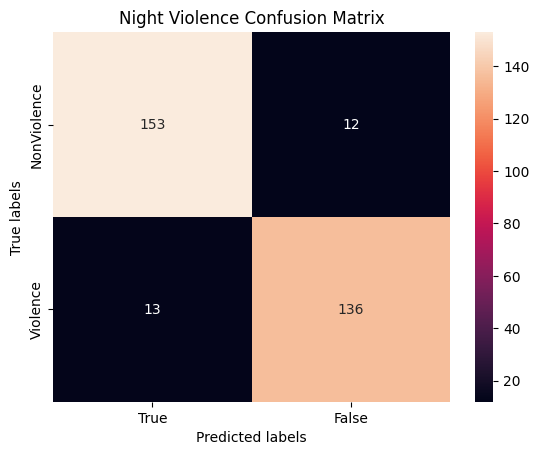

In [38]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

ax= plt.subplot()
cm=confusion_matrix(labels_test_normal, labels_predict)
sns.heatmap(cm, annot=True, fmt='g', ax=ax);

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Night Violence Confusion Matrix');
ax.xaxis.set_ticklabels(['True', 'False']); ax.yaxis.set_ticklabels(['NonViolence', 'Violence']);

Report

In [26]:
from sklearn.metrics import classification_report

ClassificationReport = classification_report(labels_test_normal,labels_predict)
print('Classification Report is : \n', ClassificationReport)

Classification Report is : 
               precision    recall  f1-score   support

           0       0.92      0.93      0.92       165
           1       0.92      0.91      0.92       149

    accuracy                           0.92       314
   macro avg       0.92      0.92      0.92       314
weighted avg       0.92      0.92      0.92       314



#Save Model

In [37]:
MoBiLSTM_model.save('Mobilenet_model.h5')
MoBiLSTM_model.save_weights('w_Mobilenet_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
